# Test notebook 
Test the model called by wandb. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os 
os.environ['MPLCONFIGDIR'] = '/myhome'
from datetime import datetime
# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), os.path.pardir)))
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from models.earlyrnn import EarlyRNN
from models.daily_earlyrnn import DailyEarlyRNN
import torch
from utils.losses.early_reward_loss import EarlyRewardLoss
from utils.losses.stopping_time_proximity_loss import StoppingTimeProximityLoss, sample_three_uniform_numbers
from utils.losses.daily_reward_loss import DailyRewardLoss
import pandas as pd
import pickle 
import wandb
import json
from utils.plots import plot_label_distribution_datasets, boxplot_stopping_times
from utils.doy import get_doys_dict_test, get_doy_stop
from utils.helpers_training import parse_args
from utils.helpers_testing import test_dataset, get_test_stats
import matplotlib.pyplot as plt
from utils.plots_test import plot_doy_prob, plot_all_doy_probs, plot_confusion_matrix, plot_probability_stopping
from models.model_helpers import count_parameters

In [6]:
# config 
class Config():
    def __init__(self):
        self.alpha = 0.6
        self.backbonemodel = "LSTM"
        self.batchsize = 256
        self.corrected = True
        self.dataroot = os.path.join(os.environ.get("HOME", os.environ.get("USERPROFILE")),"elects_data")
        self.dataset = "breizhcrops"
        self.device = "cuda"
        self.epochs = 100
        self.epsilon = 10
        self.extra_padding_list = [0]
        self.hidden_dims = 64
        self.learning_rate = 0.001
        self.loss_weight = "balanced"
        self.patience = 30
        self.resume = False
        self.sequencelength = 365
        self.validation_set = "valid"
        self.weight_decay = 0
        self.daily_timestamps = True
        self.original_time_serie_lengths = [102]
        self.loss = "daily_reward"
        self.day_head_init_bias = 5
        self.decision_head = "day"
        self.start_decision_head_training = 0
        
args = Config()
print("cuda is available: ", args.device)
print(args)

cuda is available:  cuda


## Download the model from wandb 

In [7]:
api = wandb.Api()
entity, project, sweep = "aurenore", "MasterThesis", "x6ma4kpb"
runs = api.runs(entity + "/" + project)

summary_list, config_list, name_list, sweep_list, start_date_list = [], [], [], [], []
for run in runs:
    # .summary contains output keys/values for
    # metrics such as accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    
    if run.sweep:
        sweep_list.append(run.sweep.name)
    else:
        sweep_list.append(None)
        
    start_date_list.append(run.createdAt)


runs_df = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list, "sweep": sweep_list, "start_date": start_date_list}
)
runs_df

summary  \
0    {'loss': {'testloss': 6.485212802886963, 'trai...   
1    {'elects_earliness': 0.9972527472527472, 'time...   
2    {'precision': 0.00041255783743528656, 'earline...   
3    {'_timestamp': 1717428298.3117075, 'harmonic_m...   
4    {'elects_earliness': 1, 'classification_loss':...   
..                                                 ...   
394  {'_wandb': {'runtime': 21797}, 'precision': 0....   
395  {'loss': {'testloss': 1.3871128559112549, 'tra...   
396  {'conf_mat_table': {'_type': 'table-file', 'nc...   
397  {'_wandb': {'runtime': 19318}, 'precision': 0....   
398  {'kappa': 0.6994880096526834, '_timestamp': 17...   

                                                config  \
0    {'loss': 'daily_reward', 'alpha': 1, 'device':...   
1    {'loss': 'daily_reward', 'alpha': 1, 'device':...   
2    {'loss': 'daily_reward', 'alpha': 1, 'device':...   
3    {'loss': 'daily_reward', 'alpha': 1, 'device':...   
4    {'loss': 'daily_reward', 'alpha': 1, 'device':...   
..                                                 ...   
394  {'alpha': 0.5, 'device': 'cuda', 'epochs': 100...   
395  {'alpha': 0.5, 'device': 'cpu', 'epochs': 100,...   
396  {'alpha': 0.5, 'device': 'cuda', 'epochs': 100...   
397  {'alpha': 0.5, 'device': 'cuda', 'epochs': 100...   
398  {'alpha': 0.5, 'device': 'cuda', 'epochs': 100...   

                          name                      sweep           start_date  
0              divine-sweep-12  only_classification_first  2024-06-03T15:25:10  
1           sparkling-sweep-11  only_classification_first  2024-06-03T15:18:18  
2            volcanic-sweep-10  only_classification_first  2024-06-03T15:08:53  
3                warm-sweep-15  only_classification_first  2024-06-03T14:32:18  
4                avid-sweep-14  only_classification_first  2024-06-03T14:25:11  
..                         ...                        ...                  ...  
394       TempCNN-seqlength150                       None  2024-03-28T15:16:29  
395          LSTM-seqlength150                       None  2024-03-28T15:15:39  
396        TempCNN-seqlength70                       None  2024-03-28T13:54:08  
397  ELECTS-LSTM-hiddendims=32                       None  2024-03-27T14:55:09  
398                ELECTS-LSTM                       None  2024-03-27T08:44:41  

[399 rows x 5 columns]

get the runs with certain sweep name, and created after a certain date

In [8]:
sweep_name = "only_classification_first"
# get the best run
df = runs_df[runs_df.sweep == sweep_name]
# get the runs that were created after the 1st of june 
# Convert the start_date column to datetime
df.loc[:, 'start_date'] = pd.to_datetime(df['start_date'])
# Filter rows where start_date is after 1st June 2024
df = df[df['start_date'] > datetime(2024, 6, 1)]
df

summary  \
0   {'loss': {'testloss': 6.485212802886963, 'trai...   
1   {'elects_earliness': 0.9972527472527472, 'time...   
2   {'precision': 0.00041255783743528656, 'earline...   
3   {'_timestamp': 1717428298.3117075, 'harmonic_m...   
4   {'elects_earliness': 1, 'classification_loss':...   
5   {'epoch': 100, 'earliness_reward': 2.345261573...   
6   {'alpha': 1, '_wandb': {'runtime': 2260}, 'rec...   
7   {'kappa': 0.7025487524049054, 'boxplot': {'pat...   
8   {'loss': {'testloss': 8.528017044067383, 'trai...   
9   {'_wandb': {'runtime': 3132}, 'fscore': 0.0685...   
10  {'classification_loss': 8.25942325592041, 'tim...   
11  {'_step': 72, 'alpha': 0.8933333333333333, 'ka...   

                                               config                name  \
0   {'loss': 'daily_reward', 'alpha': 1, 'device':...     divine-sweep-12   
1   {'loss': 'daily_reward', 'alpha': 1, 'device':...  sparkling-sweep-11   
2   {'loss': 'daily_reward', 'alpha': 1, 'device':...   volcanic-sweep-10   
3   {'loss': 'daily_reward', 'alpha': 1, 'device':...       warm-sweep-15   
4   {'loss': 'daily_reward', 'alpha': 1, 'device':...       avid-sweep-14   
5   {'loss': 'daily_reward', 'alpha': 1, 'device':...    gallant-sweep-13   
6   {'loss': 'daily_reward', 'alpha': 1, 'device':...      vital-sweep-12   
7   {'loss': 'daily_reward', 'alpha': 1, 'device':...    dutiful-sweep-11   
8   {'loss': 'daily_reward', 'alpha': 1, 'device':...      swept-sweep-10   
9   {'loss': 'daily_reward', 'alpha': 1, 'device':...   faithful-sweep-12   
10  {'loss': 'daily_reward', 'alpha': 1, 'device':...    stellar-sweep-11   
11  {'loss': 'daily_reward', 'alpha': 1, 'device':...       rich-sweep-10   

                        sweep           start_date  
0   only_classification_first  2024-06-03 15:25:10  
1   only_classification_first  2024-06-03 15:18:18  
2   only_classification_first  2024-06-03 15:08:53  
3   only_classification_first  2024-06-03 14:32:18  
4   only_classification_first  2024-06-03 14:25:11  
5   only_classification_first  2024-06-03 14:15:50  
6   only_classification_first  2024-06-03 13:54:19  
7   only_classification_first  2024-06-03 13:53:34  
8   only_classification_first  2024-06-03 13:37:50  
9   only_classification_first  2024-06-03 13:01:49  
10  only_classification_first  2024-06-03 13:01:46  
11  only_classification_first  2024-06-03 13:01:18

In [9]:
# get the run with the highest fscore
chosen_run_idx = df.summary.apply(lambda x: x["fscore"]).idxmax()
chosen_run = runs[chosen_run_idx]
chosen_run_config = chosen_run.config
print("chosen run: ", chosen_run.name)
print("with fscore: ", chosen_run.summary._json_dict["fscore"])

chosen run:  swept-sweep-10
with fscore:  0.7249028328325512


In [10]:
artifacts = chosen_run.logged_artifacts()
model = [artifact for artifact in artifacts if artifact.type == "model"][-1] # get the latest model artifact
model_path = model.download()
print(model_path)

# save config as json file
with open(os.path.join(model_path,"args.json"), "w") as f:
    json.dump(chosen_run_config, f)

wandb:   1 of 1 files downloaded.  


c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-6q240ha7-model.pth-v23


## Test.py - Test the model



In [11]:
# ----------------------------- LOAD DATASET -----------------------------
if args.dataset == "breizhcrops":
    dataroot = os.path.join(args.dataroot,"breizhcrops")
    input_dim = 13
    doys_dict_test = get_doys_dict_test(dataroot=os.path.join(args.dataroot,args.dataset))
    train_ds = BreizhCrops(root=dataroot,partition="train", sequencelength=args.sequencelength, corrected=args.corrected, daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths)
    test_ds = BreizhCrops(root=dataroot,partition="eval", sequencelength=args.sequencelength, corrected=args.corrected, \
        daily_timestamps=args.daily_timestamps, original_time_serie_lengths=args.original_time_serie_lengths)
    nclasses = test_ds.nclasses
    class_names = test_ds.labels_names
    print("class names:", class_names)
else:
    raise ValueError(f"dataset {args.dataset} not recognized")


2253658856 2253658856


loading data into RAM: 100%|██████████| 85310/85310 [00:43<00:00, 1942.53it/s]


2493572704 2493572704


loading data into RAM: 100%|██████████| 2463/2463 [00:01<00:00, 1900.90it/s]


1555075632 1555075632


loading data into RAM: 100%|██████████| 36915/36915 [00:19<00:00, 1886.63it/s]

class names: ['barley' 'wheat' 'rapeseed' 'corn' 'orchards' 'permanent meadows'
 'temporary meadows']


In [14]:
# print the difference between chosen_run_config and args
for key, value in chosen_run_config.items():
    if key not in args.__dict__:
        print(f"key {key} not in args, adding it with value {value}")
        args.__dict__[key] = value
    elif args.__dict__[key] != value:
        print(f"key {key} is different: {args.__dict__[key]} != {value}")
        # if the key is different, update it, unless it is the dataroot
        if key != "dataroot":
            print(f"adding the new value {value} to args")
            args.__dict__[key] = value

key dataroot is different: C:\Users\anyam\elects_data != /home/amauron/elects/data/elects_data


In [15]:
# ----------------------------- LOAD MODEL -----------------------------
if args.decision_head == "day":
        dict_model = {"start_decision_head_training": args.start_decision_head_training if hasattr(args, "start_decision_head_training") else 0,}
        model = DailyEarlyRNN(args.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=args.sequencelength, hidden_dims=args.hidden_dims, day_head_init_bias=args.day_head_init_bias, **dict_model).to(args.device)
else:
    model = EarlyRNN(args.backbonemodel, nclasses=nclasses, input_dim=input_dim, sequencelength=args.sequencelength, hidden_dims=args.hidden_dims, left_padding=args.left_padding).to(args.device)

print("model is loading from: ", model_path)
model.load_state_dict(torch.load(os.path.join(model_path, "model.pth")))

# criterion
if args.loss_weight == "balanced":
    class_weights = train_ds.get_class_weights().to(args.device)
else: 
    class_weights = None

if args.loss == "early_reward":
    criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon, weight=class_weights)
elif args.loss == "stopping_time_proximity":
    alpha4 = 1-args.alpha1-args.alpha2-args.alpha3
    args.update({"alpha4": alpha4})
    criterion = StoppingTimeProximityLoss(alphas=[args.alpha1, args.alpha2, args.alpha3, args.alpha4], weight=class_weights)
elif args.loss == "daily_reward":
    criterion = DailyRewardLoss(alpha=args.alpha, weight=class_weights, alpha_decay=args.alpha_decay, epochs=args.epochs, start_decision_head_training=args.start_decision_head_training if hasattr(args, "start_decision_head_training") else 0)
else: 
    print(f"loss {args.loss} not recognized, loss set to default: early_reward")
    criterion = EarlyRewardLoss(alpha=args.alpha, epsilon=args.epsilon, weight=class_weights)

print(f"The model has {count_parameters(model):,} trainable parameters.")



model is loading from:  c:\Users\anyam\Desktop\Master_thesis\Code\elects\artifacts\run-6q240ha7-model.pth-v23
The model has 66,978 trainable parameters.


Extracting labels from dataset Test.


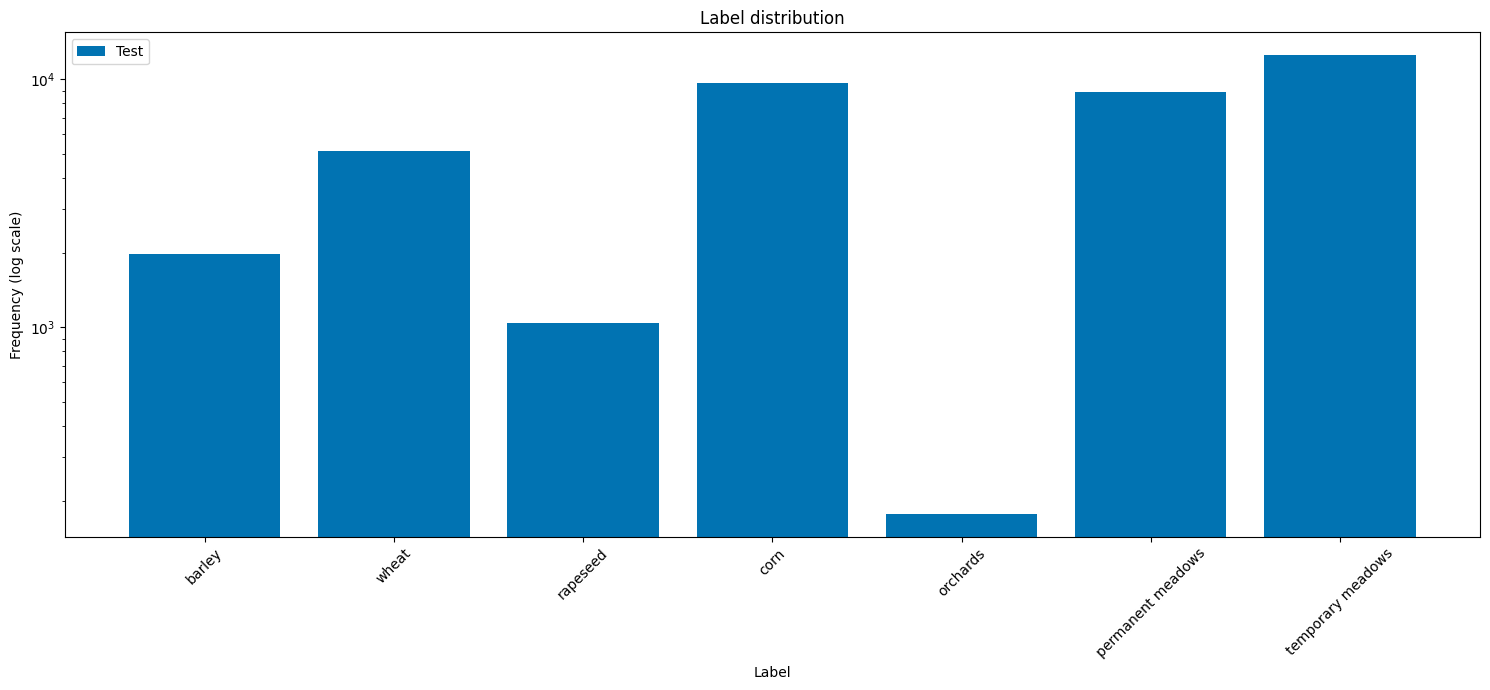

In [16]:
# take about 1 minute
# ----------------------------- VISUALIZATION: label distribution -----------------------------
datasets = [test_ds]
sets_labels = ["Test"]
fig, ax = plt.subplots(figsize=(15, 7))
fig, ax = plot_label_distribution_datasets(datasets, sets_labels, fig, ax, title='Label distribution', labels_names=class_names)

## Test the model with the test dataset

In [18]:
# ----------------------------- TEST -----------------------------
# if the files do not exist, they will be created
if os.path.exists(os.path.join(model_path, "testloss.pkl")) and os.path.exists(os.path.join(model_path, "stats.pkl")):
    print("testloss.pkl and stats.pkl exist. Loading them.")
    with open(os.path.join(model_path, "testloss.pkl"), "rb") as f:
        testloss = pickle.load(f)
    with open(os.path.join(model_path, "stats.pkl"), "rb") as f:
        stats = pickle.load(f)
else: 
    print("testloss.pkl or stats.pkl does not exist. Running test.")
    testloss, stats = test_dataset(model, test_ds, criterion, args.device, args.batchsize, extra_padding_list=args.extra_padding_list, \
        return_id=test_ds.return_id, daily_timestamps=args.daily_timestamps, kwargs={"epoch": 100, "criterion_alpha": args.alpha_decay[1]})

    # with open(os.path.join(model_path, "testloss.pkl"), "wb") as f:
    #     pickle.dump(testloss, f)
    # print("test loss saved to", os.path.join(model_path, "testloss.pkl"))

    # with open(os.path.join(model_path, "stats.pkl"), "wb") as f:
    #     pickle.dump(stats, f)
    # print("stats saved to", os.path.join(model_path, "stats.pkl"))
    
test_stats = get_test_stats(stats, testloss, args)

testloss.pkl or stats.pkl does not exist. Running test.


In [19]:
test_stats

{'test_loss': 7.8232517,
 'accuracy': 0.7084412616181625,
 'precision': 0.7114574860011639,
 'recall': 0.7797753523914751,
 'fscore': 0.6964749658616592,
 'kappa': 0.6389715659163266,
 'elects_earliness': 0.0,
 'classification_loss': 7.8232517,
 'earliness_reward': 0.0,
 'harmonic_mean': 0.0}

## Graphs

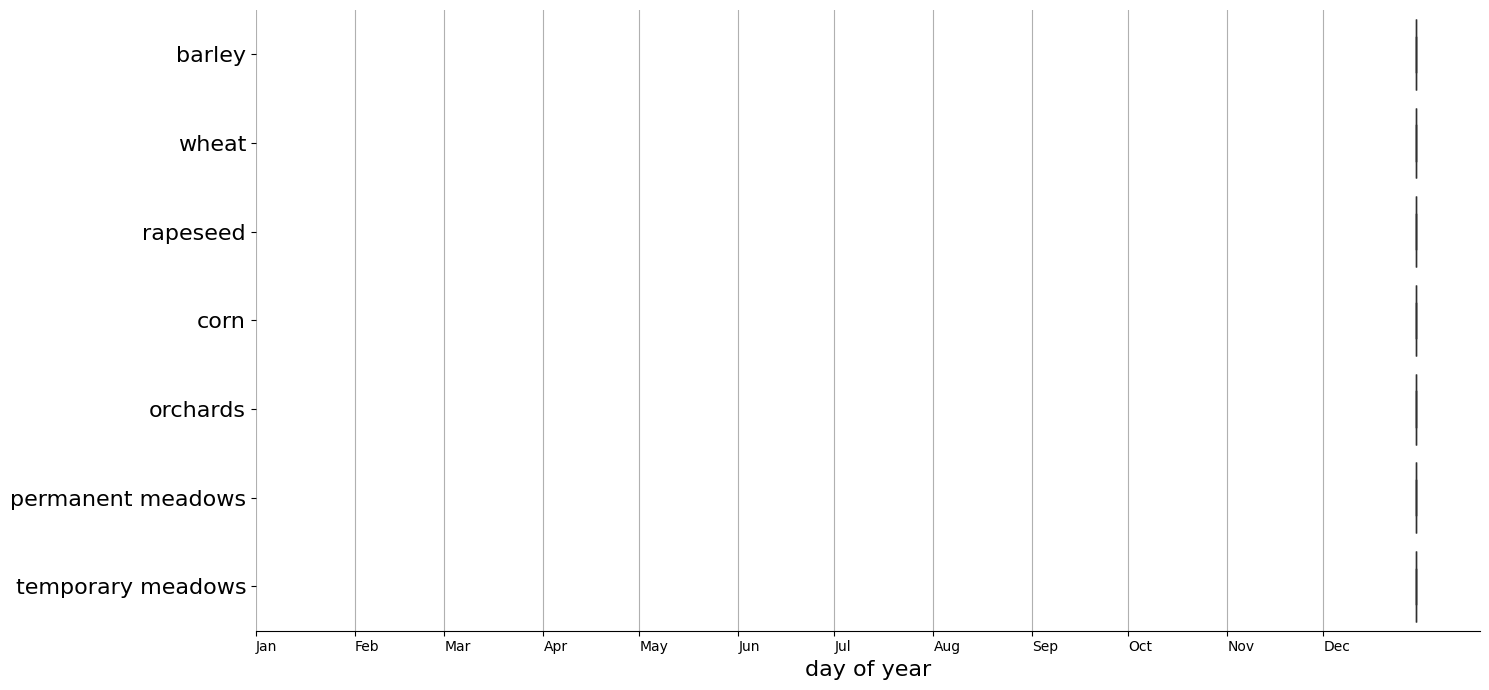

In [20]:
# ----------------------------- VISUALIZATION: stopping times -----------------------------
fig_boxplot, ax_boxplot = plt.subplots(figsize=(15, 7))
if args.daily_timestamps:
    doys_stop = stats["t_stop"].squeeze()
else: 
    doys_dict = get_approximated_doys_dict(stats["seqlengths"], length_sorted_doy_dict_test)
    doys_stop = get_doy_stop(stats, doys_dict)
fig_boxplot, _ = boxplot_stopping_times(doys_stop, stats, fig_boxplot, ax_boxplot, class_names)
                
fig_boxplot.savefig(os.path.join(model_path, "boxplot_stopping_times.png"))

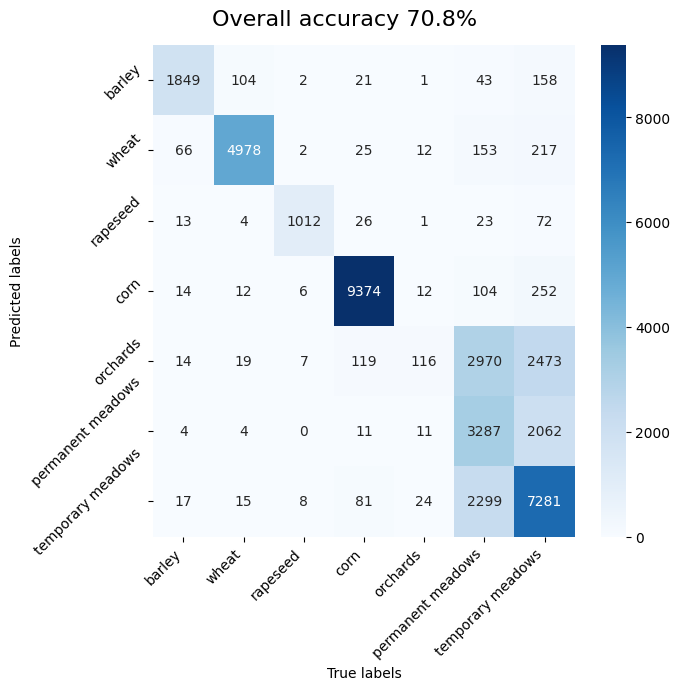

In [21]:
fig, ax = plt.subplots(figsize=(7,7))
fig = plot_confusion_matrix(stats["targets"][:, 0], stats["predictions_at_t_stop"].flatten(), class_names, fig, ax)
fig.savefig(os.path.join(model_path, "confusion_matrix.png"))

In [45]:
class_prob = stats["class_probabilities"]
y_true = stats["targets"][:, 0]
print("class_prob.shape: ", class_prob.shape)
print("y_true shape: ", y_true.shape)

class_prob.shape:  (39378, 365, 7)
y_true shape:  (39378,)


(array([0.0502057 , 0.13042816, 0.0263345 , 0.24523846, 0.0044949 ,
        0.22548123, 0.31781706]),
 array([0., 1., 2., 3., 4., 5., 6., 7.]),
 <BarContainer object of 7 artists>)

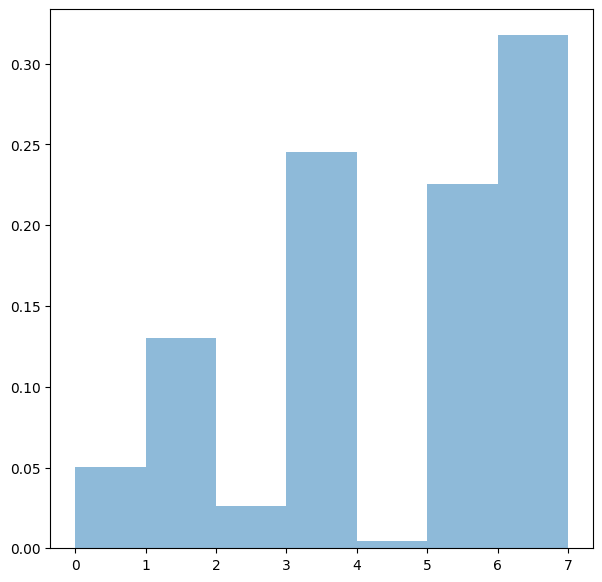

In [49]:
# distribution of y_true
fig, ax = plt.subplots(figsize=(7,7))
ax.hist(y_true, bins=range(len(class_names)+1), density=True, alpha=0.5, label="y_true")

In [64]:
def plot_class_prob_wrt_time(fig, ax, label, class_prob, y_true, class_names, model_path, alpha=0.2):
    print("label: ", label)
    # for this label, compute the mean probability and the std through time 
    mean_prob = class_prob[y_true == label].mean(axis=0)
    std_prob = class_prob[y_true == label].std(axis=0)
    # Loop through each dimension to plot separately
    for i in range(mean_prob.shape[1]):
        current_label = class_names[i]
        if i==label:
            current_label = f"{current_label} (true)"
        ax.plot(mean_prob[:, i], label=f"mean {current_label}")
        ax.fill_between(range(mean_prob.shape[0]), 
                        mean_prob[:, i] - std_prob[:, i], 
                        mean_prob[:, i] + std_prob[:, i], 
                        alpha=alpha, label=f"std {current_label}")

    ax.set_title(f"Class {class_names[label]} probability through time")
    ax.set_xlabel("Time")
    ax.set_ylabel("Probability")
    ax.legend()


label:  0
label:  1
label:  2
label:  3
label:  4
label:  5
label:  6


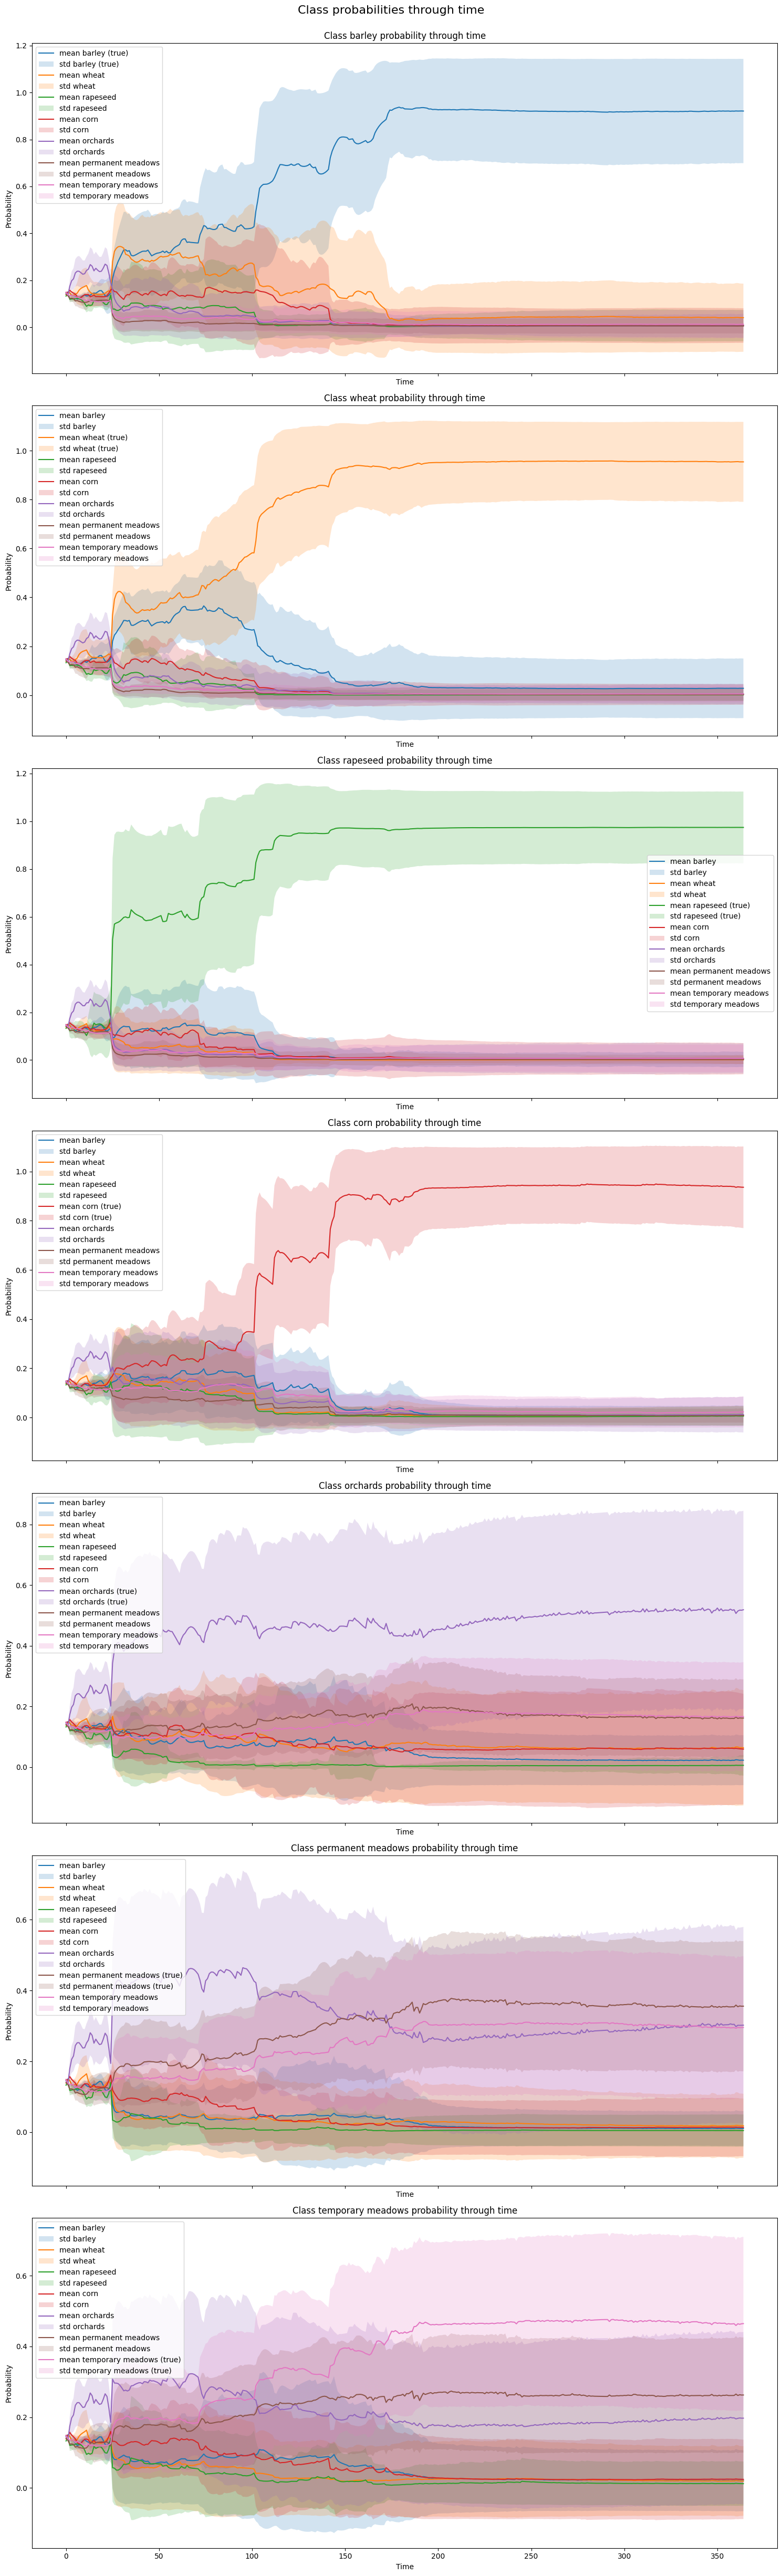

In [65]:
# -- visualize the class probabilities through time for each class
fig, axes = plt.subplots(figsize=(15, 7*len(class_names)), nrows=len(class_names), sharex=True)
for label in range(len(class_names)):
    plot_class_prob_wrt_time(fig, axes[label], label, class_prob, y_true, class_names, model_path)
fig.suptitle("Class probabilities through time", fontsize=16, y=1.)
fig.tight_layout()


(<Figure size 600x400 with 1 Axes>, <Axes: >)

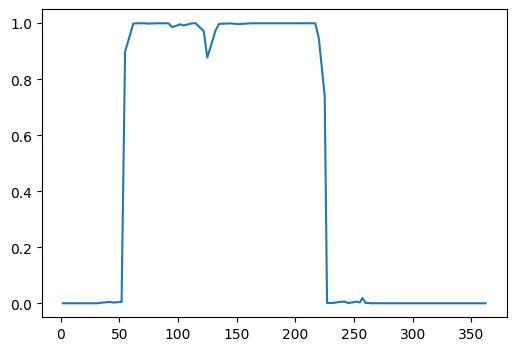

In [30]:
fig, ax = plt.subplots(figsize=(6,4))
plot_doy_prob(6052609, stats, doys_dict_test, model, args.device, test_ds, fig, ax)

for class 0 we have 500 samples
for class 1 we have 500 samples
for class 2 we have 500 samples
for class 3 we have 500 samples
for class 4 we have 2 samples
for class 5 we have 500 samples
for class 6 we have 11 samples
for class 7 we have 500 samples
for class 8 we have 500 samples


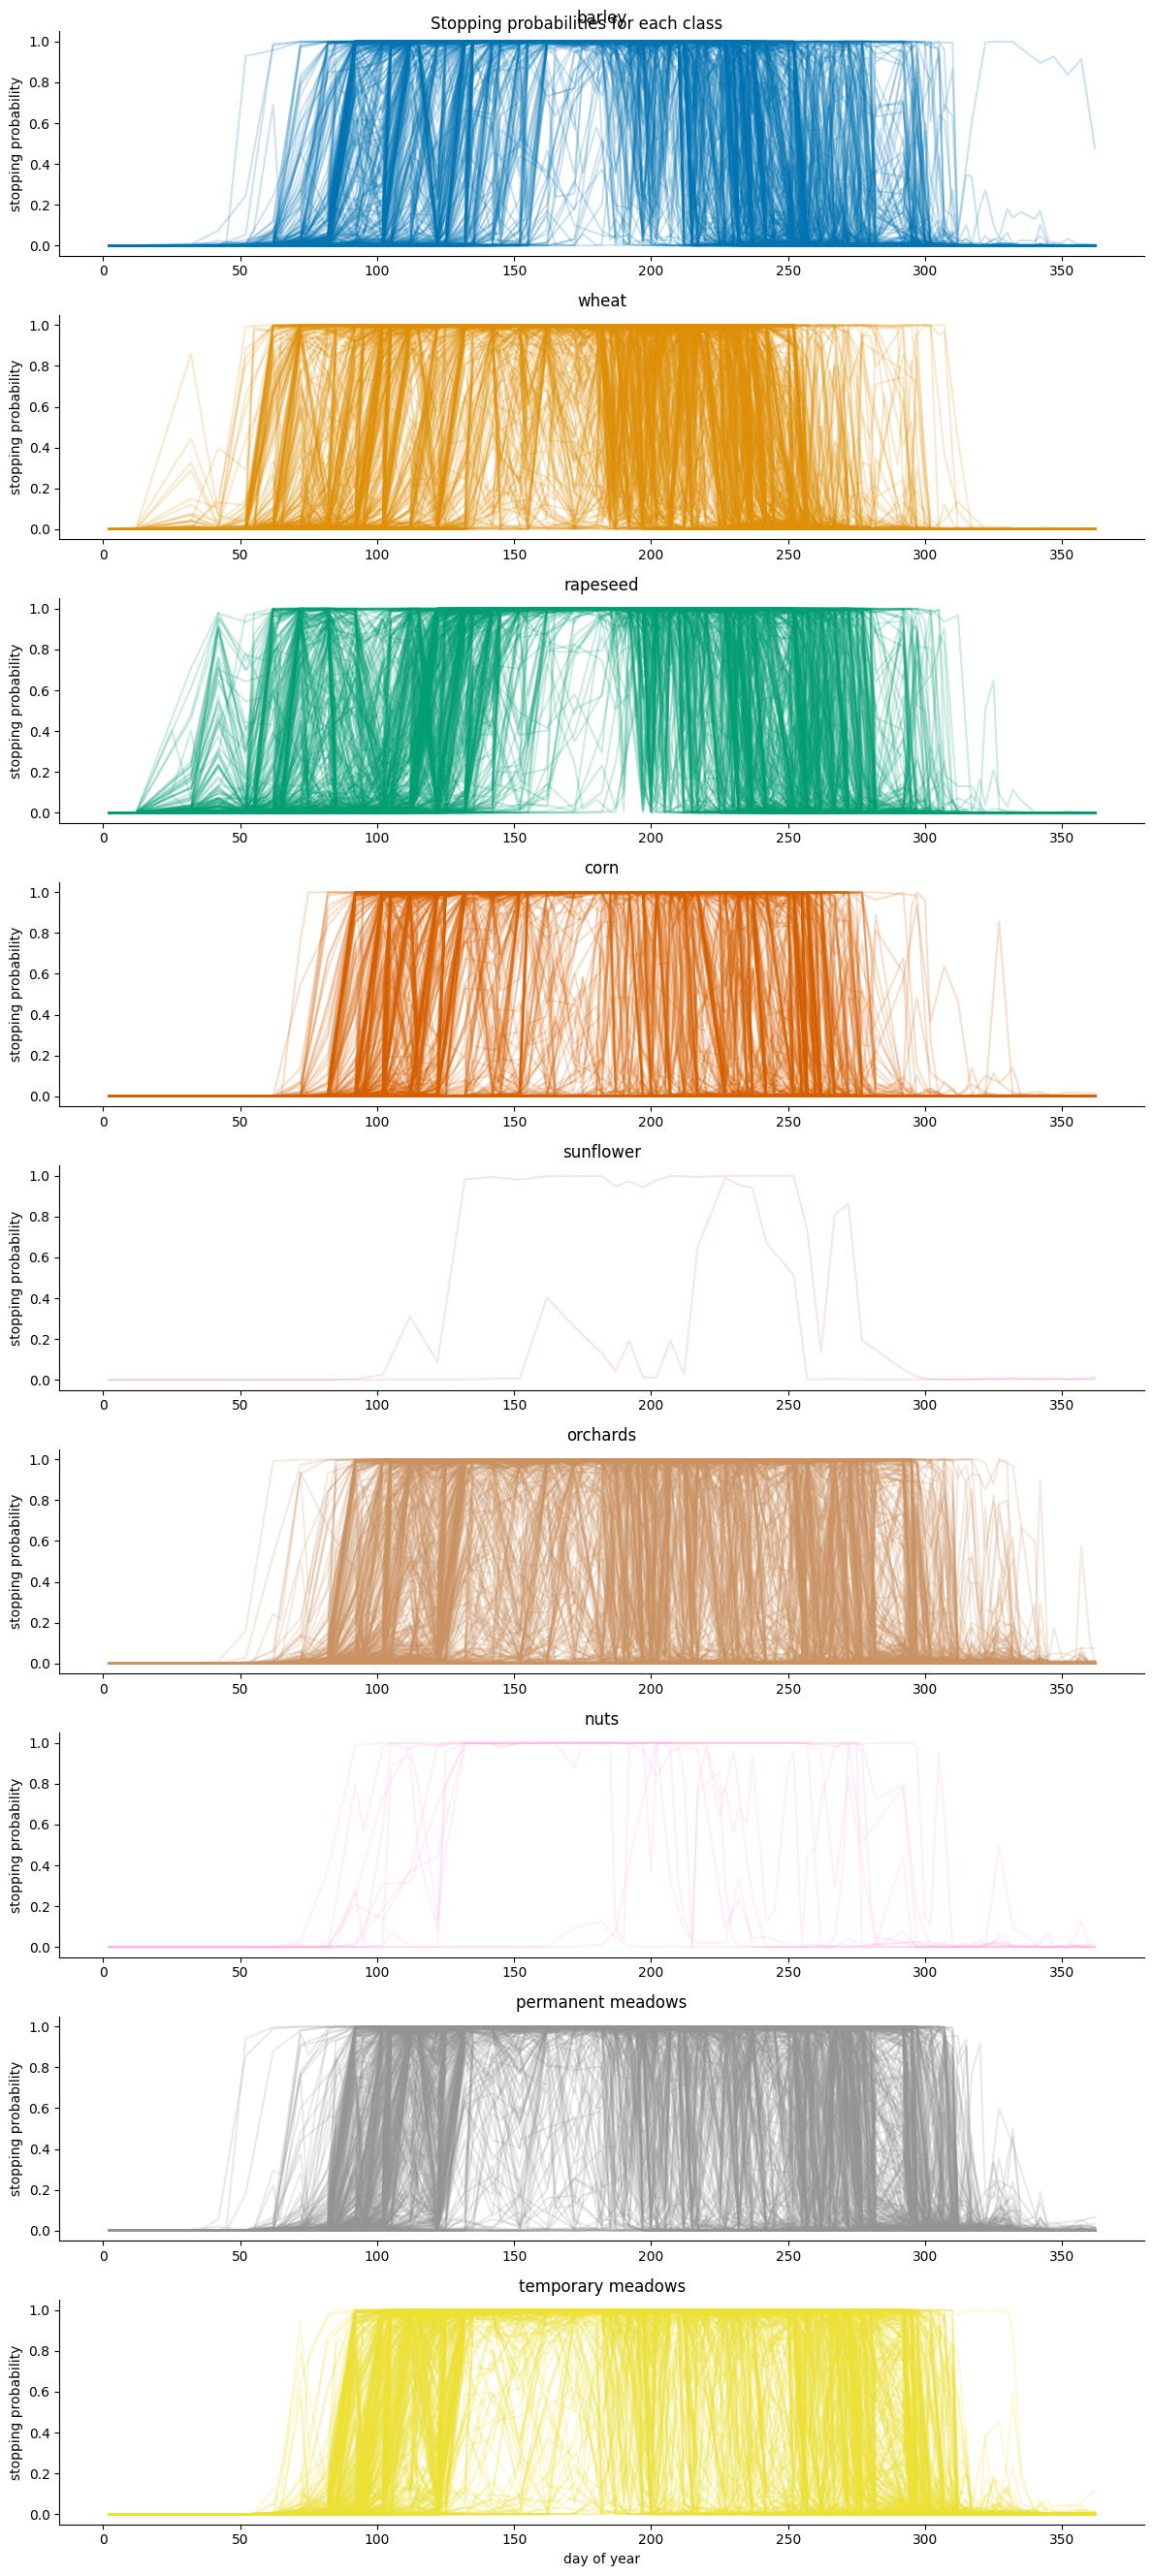

In [31]:
fig, axes = plot_all_doy_probs(stats, doys_dict_test, nclasses=nclasses, class_names=class_names, alpha=0.2, nsamples=500)
fig.savefig(os.path.join(model_path, "doy_probs.png"))

## Analyse the probability of stopping

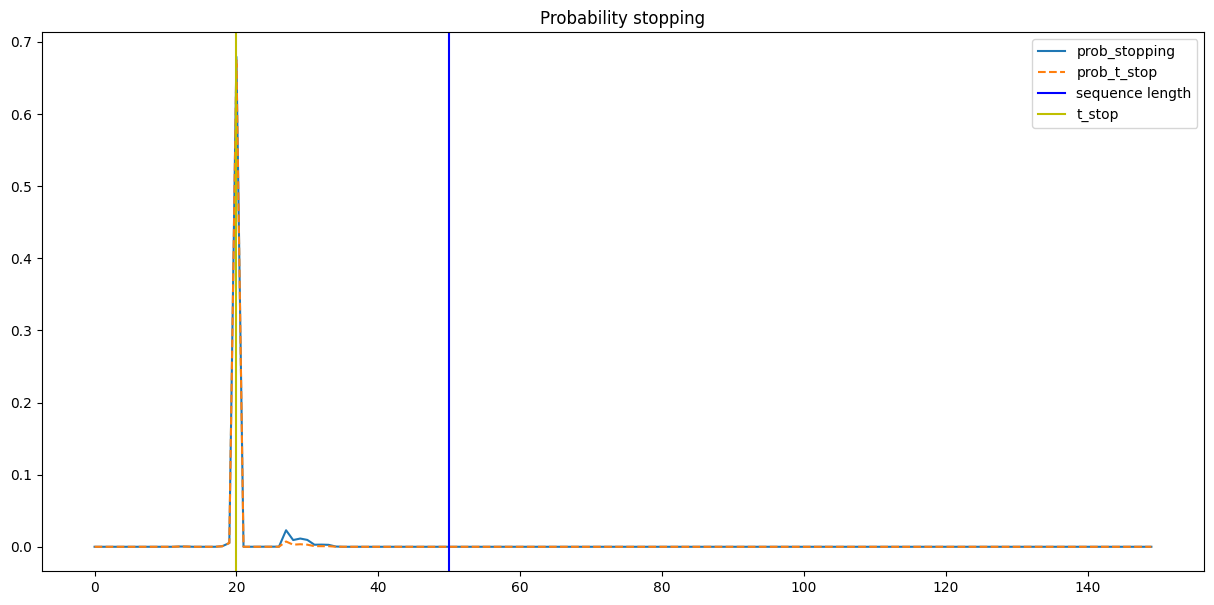

In [39]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -1
ax = plot_probability_stopping(stats, index, ax)

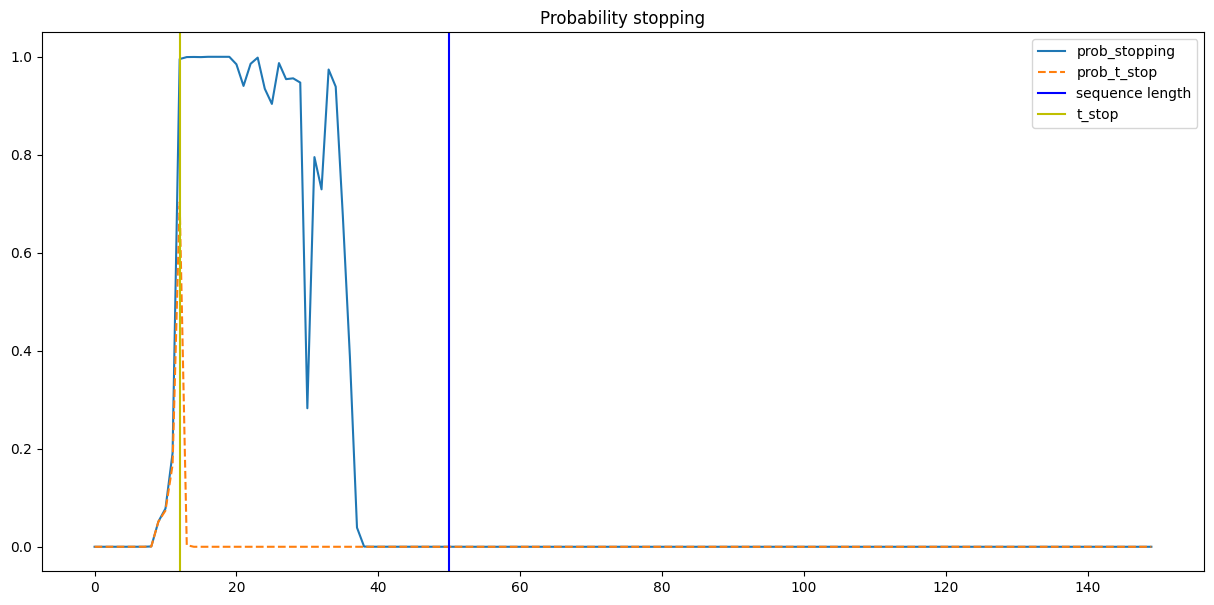

In [40]:
# plot the probability stopping 
fig, ax = plt.subplots(figsize=(15, 7))
index = -5
ax = plot_probability_stopping(stats, index, ax)